In [3]:
from __future__ import print_function
from collections import defaultdict
import grpc
import time
import datetime
import outdoor_temperature_pb2
import outdoor_temperature_pb2_grpc
import pandas as pd
import requests
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil import parser
import pytz


In [4]:
BUILDING_COORDINATES = {
"orinda-public-library":"37.8830553,-122.1900413",
"orinda-community-center":"37.8830553,-122.1900413",
"hayward-station-1":"37.6465448,-122.1187695",
"hayward-station-8":"37.675162,-122.0322595",
"avenal-animal-shelter":"36.001755,-120.113438",
"avenal-movie-theatre":"36.0026293,-120.137419",
"avenal-public-works-yard":"36.001972,-120.112119",
"avenal-recreation-center":"36.008819,-120.127677",
"avenal-veterans-hall":"36.001972,-120.112119",
"south-berkeley-senior-center":"37.85436,-122.2751013",
"north-berkeley-senior-center":"37.8736888,-122.2750438",
"berkeley-corporation-yard":"37.8660023,-122.2875179",
"word-of-faith-cc":"38.273656,-121.9611537",
"local-butcher-shop":"37.8780587,-122.2715741",
"jesse-turner-center":"34.0961567,-117.5393781",
"ciee":"37.8751,-122.2761",
"csu-dominguez-hills":"33.8633706,-118.2574696"
}


In [5]:
def get_processed_weather(building,st,en,window):
    with grpc.insecure_channel('localhost:50051') as channel:
        stub = outdoor_temperature_pb2_grpc.OutdoorTemperatureStub(channel)
        try:
            start = int(time.mktime(datetime.datetime.strptime(st, "%d/%m/%Y %H:%M:%S").timetuple())*1e9)
            end =  int(time.mktime(datetime.datetime.strptime(en, "%d/%m/%Y %H:%M:%S").timetuple())*1e9)
            response = stub.GetTemperature(outdoor_temperature_pb2.TemperatureRequest(building=building,start=start,end=end,window=window))
            weather_times = []
            weather_temperatures = []
            for temperature in response.temperatures:
#                 weather_times.append(time.ctime(int(temperature.time/1e9)))
                weather_times.append(pd.to_datetime(temperature.time/1e9,unit='s'))
                weather_temperatures.append(temperature.temperature)                                     
            weather_data = pd.Series(data=weather_temperatures, index=weather_times)
            return weather_data
        except grpc.RpcError as e:
            print(e)


In [6]:
def get_raw_weather(building):
    try:
        coordinates = BUILDING_COORDINATES[building]
        weather_meta = requests.get("https://api.weather.gov/points/" + coordinates).json()
        weather_json = requests.get(weather_meta["properties"]["forecastHourly"])
        weather_data_dictionary = weather_json.json()
    except Exception as e:
        print("Failed to fetch data from weather service",e)
    weather_times = []
    weather_temperatures = []
    for row in weather_data_dictionary["properties"]["periods"]:
        weather_times.append(parser.parse(row["startTime"]))
        if row["temperatureUnit"] =="F":
            weather_temperatures.append(row["temperature"])
        elif row["temperatureUnit"] =="C":
            weather_temperatures.append(9.0/5.0 * row["temperature"] + 32)
        else:
            print("Weather fetch got data which was not Fahrenheit or Celsius. It had units: %s" % row["temperatureUnit"])
            return outdoor_temperature_pb2.TemperatureReply(temperatures=[]), "Weather fetch got data which was not Fahrenheit or Celsius. It had units: %s" % row["temperatureUnit"]
    weather_data = pd.Series(data=weather_temperatures, index=weather_times)
    return weather_data


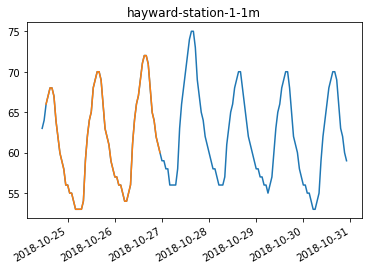

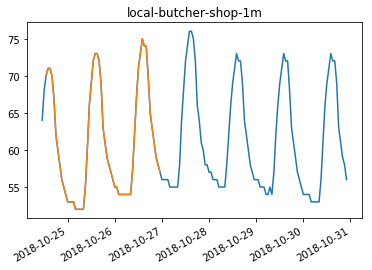

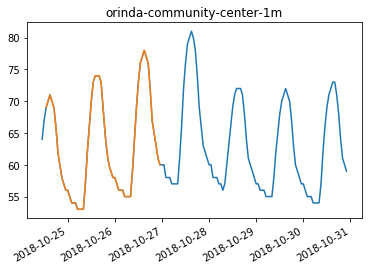

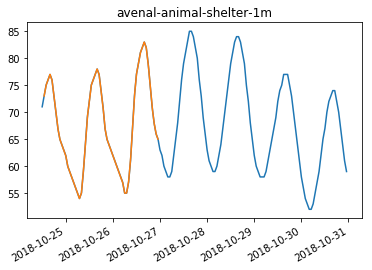

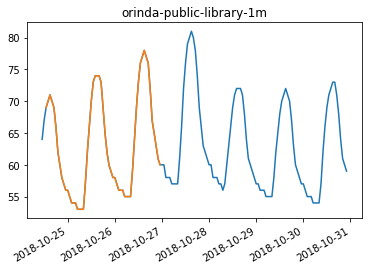

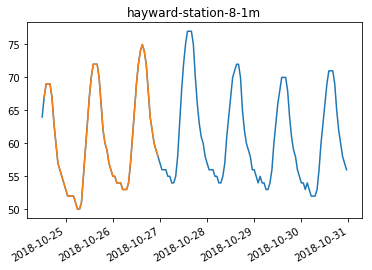

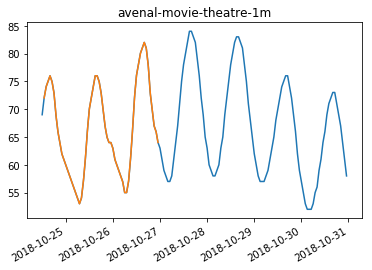

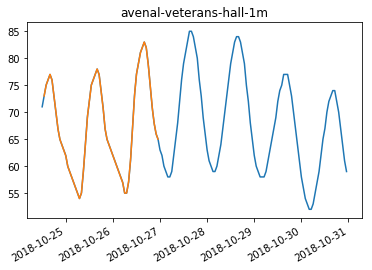

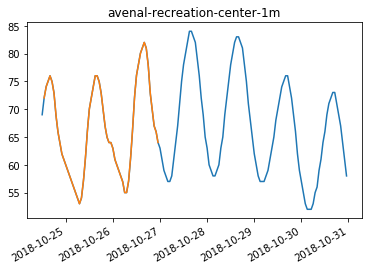

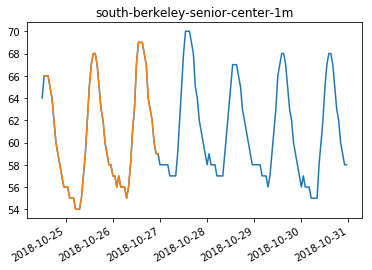

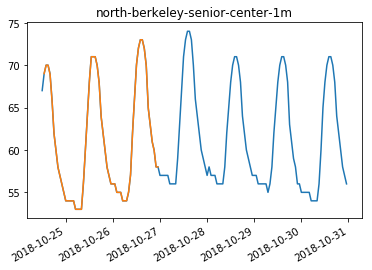

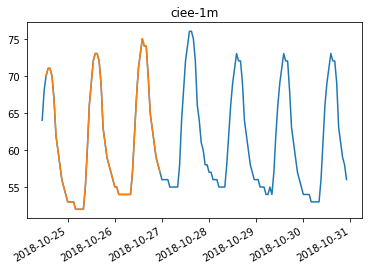

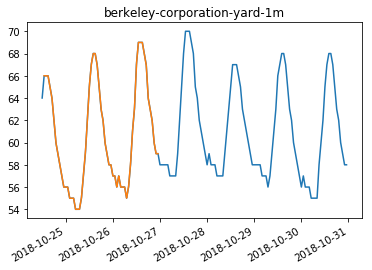

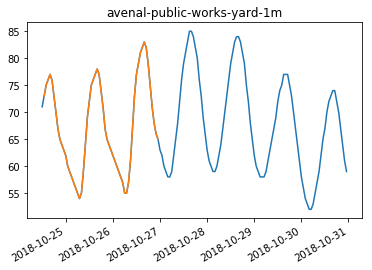

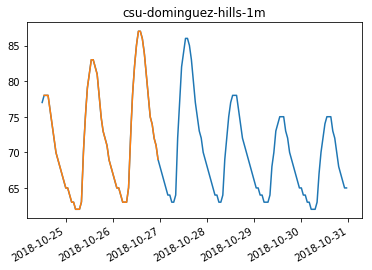

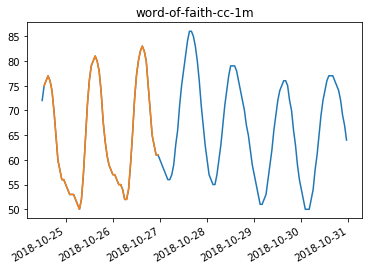

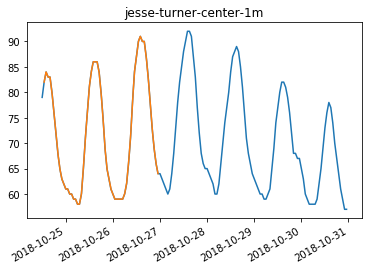

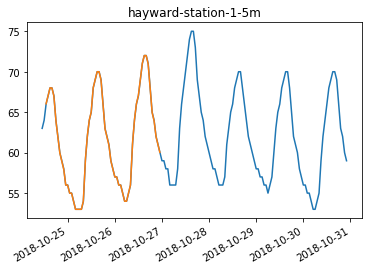

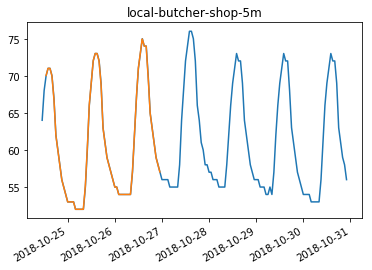

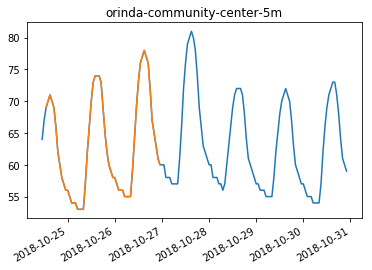

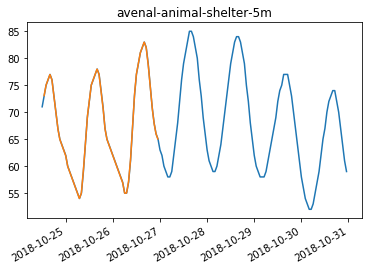

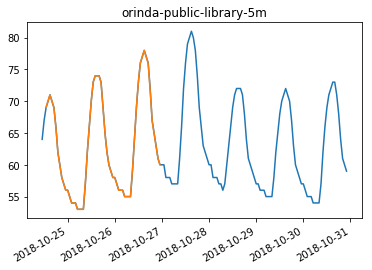

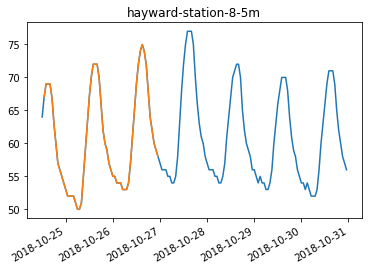

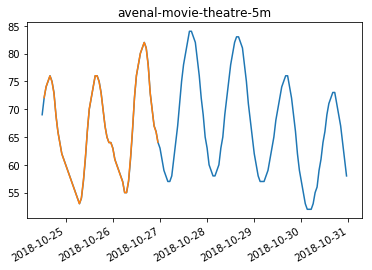

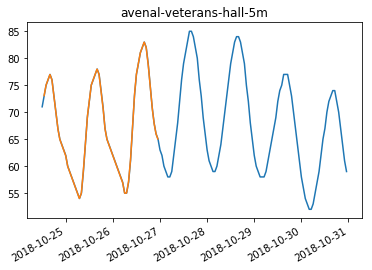

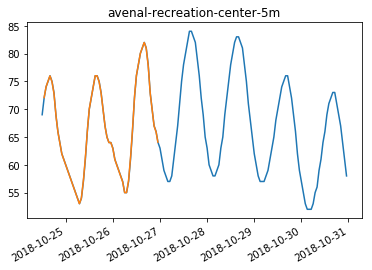

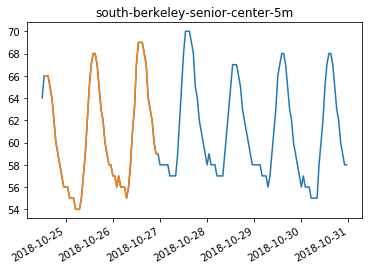

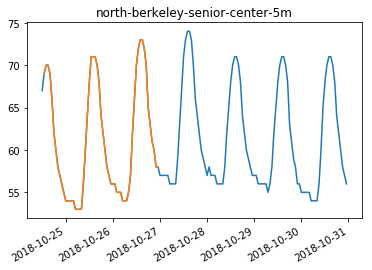

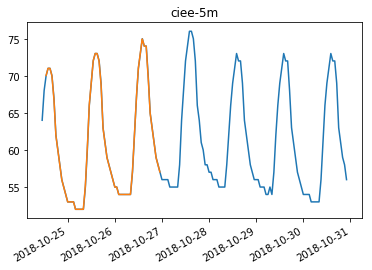

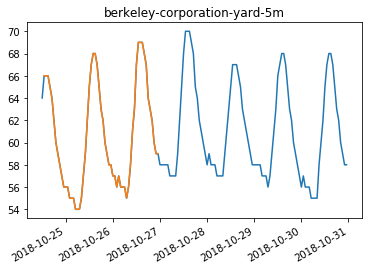

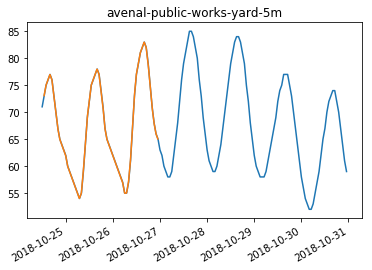

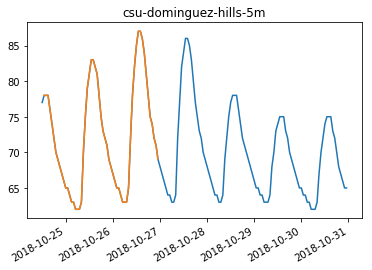

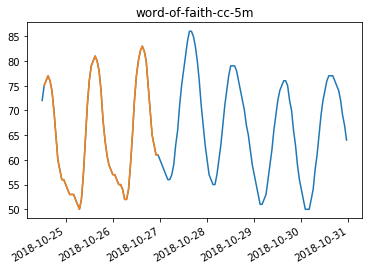

Failed to fetch data from weather service HTTPSConnectionPool(host='api.weather.gov', port=443): Max retries exceeded with url: /points/34.0961567,-117.5393781 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x10ec7fb90>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))


UnboundLocalError: local variable 'weather_data_dictionary' referenced before assignment

In [7]:
st_time = "24/10/2018 13:00:00"
en_time = "26/10/2018 23:00:00"
windows = ["1m","5m","15m","30m","45m","1h","2h","4h"]


for window in windows:
    for building in BUILDING_COORDINATES:
        ax=get_raw_weather(building).plot()
        get_processed_weather(building,st_time,en_time,window).plot(ax=ax,title=building+"-"+window)
        plt.show()




In [ ]:
#Summary works for windows <= 1h 